In [2]:
#For mounting to drive
from google.colab import drive

#Mount folder to save and retrieve outputs
drive.mount('/content/Drive3',force_remount=True)
%cd "/content/Drive3/My Drive/ML/FraudDetection/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/Drive3
/content/Drive3/My Drive/ML/FraudDetection


In [0]:
# to unzip data from Kaggle
from zipfile import ZipFile

with ZipFile('ieee-fraud-detection.zip', 'r') as zipObj:
   zipObj.extractall()

In [5]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('train_transaction.csv')

# Show the contents
print(df.head())

   TransactionID  isFraud  TransactionDT  ...  V337 V338  V339
0        2987000        0          86400  ...   NaN  NaN   NaN
1        2987001        0          86401  ...   NaN  NaN   NaN
2        2987002        0          86469  ...   NaN  NaN   NaN
3        2987003        0          86499  ...   NaN  NaN   NaN
4        2987004        0          86506  ...   0.0  0.0   0.0

[5 rows x 394 columns]


In [6]:
print(df.describe())

       TransactionID        isFraud  ...           V338           V339
count   5.905400e+05  590540.000000  ...   82351.000000   82351.000000
mean    3.282270e+06       0.034990  ...     151.160542     100.700882
std     1.704744e+05       0.183755  ...    1095.034387     814.946722
min     2.987000e+06       0.000000  ...       0.000000       0.000000
25%     3.134635e+06       0.000000  ...       0.000000       0.000000
50%     3.282270e+06       0.000000  ...       0.000000       0.000000
75%     3.429904e+06       0.000000  ...       0.000000       0.000000
max     3.577539e+06       1.000000  ...  104060.000000  104060.000000

[8 rows x 380 columns]


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

In [0]:
# reset the index of dataframe 'data' before running any sklearn code to prevent "ValueError: Input contains NaN"
# did not help 
data = df.reset_index()

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [37]:
#for preproccess
train_transaction = reduce_mem_usage(pd.read_csv('train_transaction.csv')) 

Mem. usage decreased to 542.35 Mb (69.4% reduction)


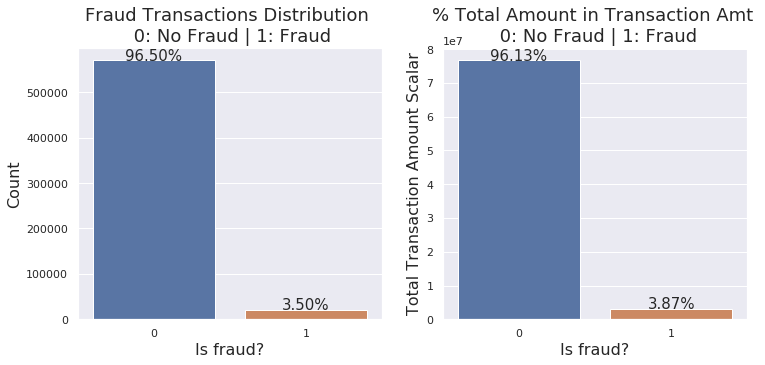

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15)

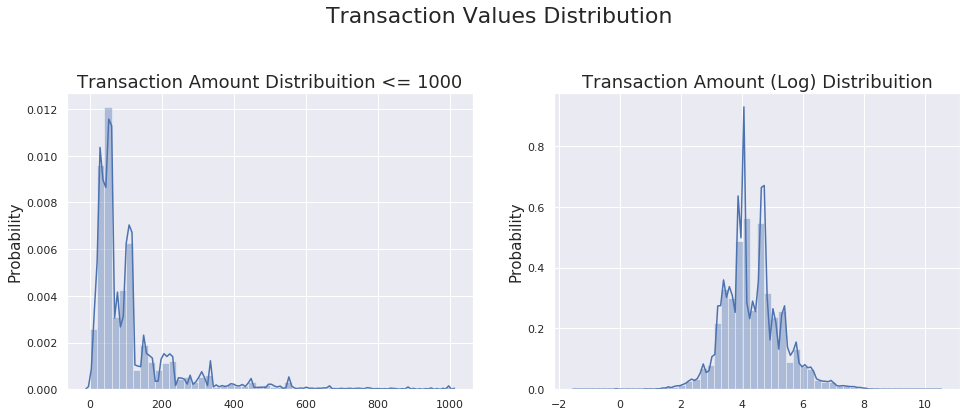

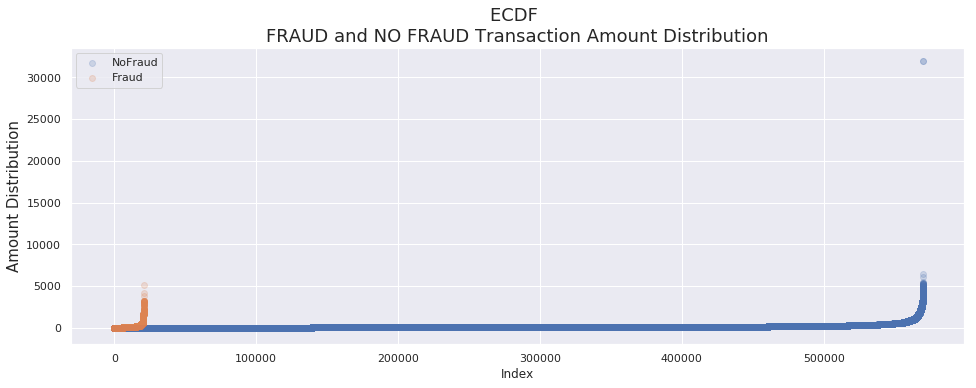

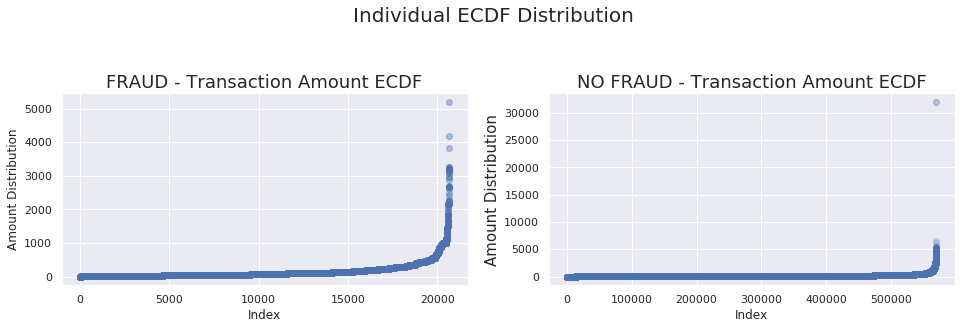

In [40]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()

In [0]:
# Only use the 'Amount' and 'V1', ..., 'V28' features
features = ['TransactionAmt'] + ['V%d' % number for number in range(1, 29)]

# The target variable which we would like to predict, is the 'Class' variable
target = 'isFraud'

# Now create an X variable (containing the features) and an y variable (containing only the target variable)
X = data[features]
y = data[target]

In [31]:
import numpy as np
np.any(np.isnan(X))
X.head()

,TransactionAmt,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,68.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,59.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
df_imputed = pd.DataFrame(imputer.fit_transform(X))
df_imputed.head()
X = df_imputed

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

In [34]:
# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    X_train, y_train = X.loc[train_indices], y.loc[train_indices]
    X_test, y_test = X.loc[test_indices], y.loc[test_indices]
    
    # Normalize the data
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    
    # Fit and predict!
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # And finally: show the results
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.67      0.03      0.05     10331

    accuracy                           0.97    295270
   macro avg       0.82      0.51      0.52    295270
weighted avg       0.96      0.97      0.95    295270

